In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [53]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    torch.fft.fft2,
    torch.fft.fftshift, 
    torch.abs,
    torch.sigmoid, 
    #transforms.Normalize(0.5, 0.5), 
    
])

valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    torch.fft.fft2,
    torch.fft.fftshift, 
    torch.abs,
    torch.sigmoid, 
    #transforms.Normalize(0.5, 0.5)  
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    torch.fft.fft2,
    torch.fft.fftshift, 
    torch.abs,
    torch.sigmoid, 
    #transforms.Normalize(0.5, 0.5)  
])


# Create training set (with no transformations)
raw_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=None)

# Split the training data into pure training data and validation data (80/20 split)
train_size = int(len(raw_data) * 0.6) # 60% training data
valid_size = int(len(raw_data) * 0.2) # 20% validation data
test_size = len(raw_data)-(train_size+valid_size)

training_data, validation_data, testing_data = torch.utils.data.random_split(raw_data, [train_size, valid_size, test_size])

# Apply the respective transformations to each dataset
training_data.dataset.transform = train_transforms
validation_data.dataset.transform = valid_transforms
testing_data.dataset.transform = test_transforms

# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=32)
test_loader = DataLoader(testing_data, batch_size=32)

3


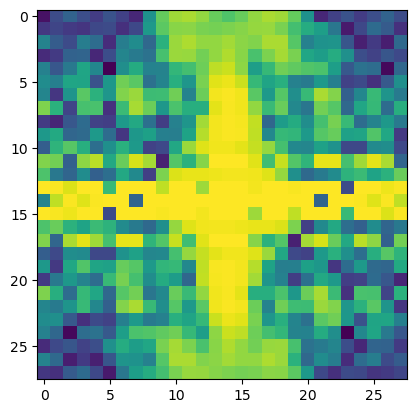

0


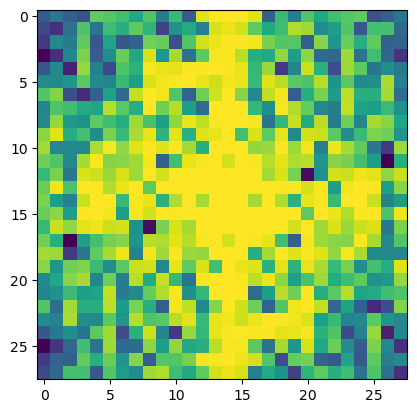

9


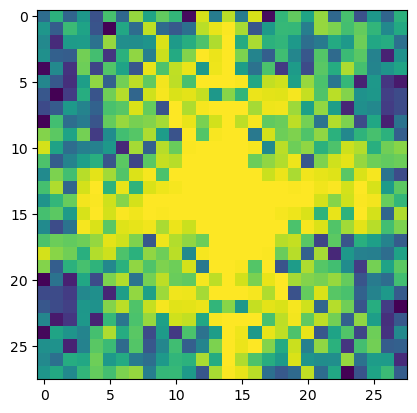

1


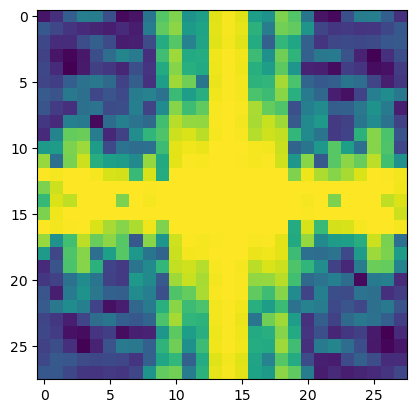

7


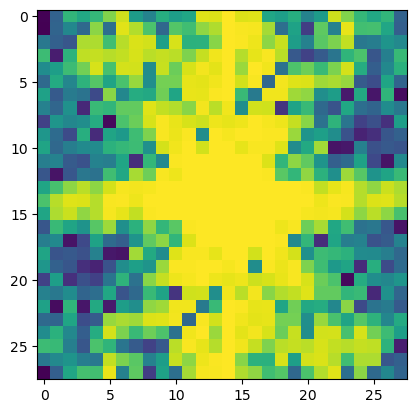

In [54]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()
        
# Explore data
show5(train_loader)

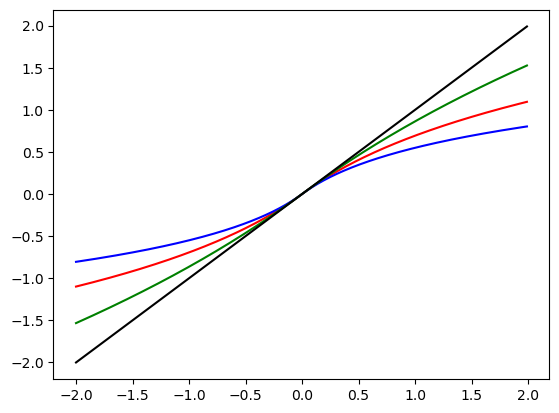

In [42]:
# Note: defining it with the sign function was the only way I could get it to work.
# Heaviside doesn't implement gradients
# torch.where gave NaN for grads at x=±a

# def Slog(x, a=1):
#     return torch.sign(x)*a*torch.log(torch.sign(x)*x/a+1)

class Slog(nn.Module): 
    def __init__(self, a=1): 
        super(Slog, self).__init__()
        self.a = a
          
    def forward(self, x): 
        return torch.sign(x)*self.a*torch.log(torch.sign(x)*x/self.a+1)

x=torch.arange(-2,2,.01)
k1=Slog(a=1)
k2=Slog(a=1/2)
k3=Slog(a=3)
y1=k1(x)
y2=k2(x)
y3=k3(x)
plt.plot(x, y1, 'red')
plt.plot(x, y2, 'blue')
plt.plot(x, y3, 'green')
plt.plot(x, x, 'black')
plt.show()

In [55]:
class Net(nn.Module):
    def __init__(self, features=[256, 128], drop_rate=.2, momentum=.9, learning_rate=.001, weight_decay=0):
        """
        The Neural Network class. 
        Note: the optimizer and criterion are specified in this class itself
        ...

        Attributes
        ----------
        features : list of integers, optional, default=[256, 128]
            sets the number of features in the two hidden layers
        drop_rate : float, optional, default=.2
            sets the dropout rate
        momentum : float, optional, default=.9
            sets the momentum coefficient of the optimizer
        learning_rate : float, optional, default=.001
            sets the learning rate of the optimizer

        Methods
        -------
        train_it(epochs=10)
            trains the network, prints loss and accuracy, and returns training and validation loss history as lists
            
        test_it()
            tests the network on the test set and prints loss and accuracy
        """
        
        # Initialize base class
        super().__init__()
        
        #Define parameters
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(28*28, features[0])
        self.drop1 = nn.Dropout(p=drop_rate)
        self.fc2 = nn.Linear(features[0], features[1])
        self.drop2 = nn.Dropout(p=drop_rate)
        self.fc3 = nn.Linear(features[1], 10)
        self.output = nn.LogSoftmax(dim=1)
        
        # Define optimizer and criterion
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        self.criterion = nn.NLLLoss()
    
        
    def forward(self, x):
        x = torch.flatten(x,1)
        x = self.activation(self.fc1(x))
        x = self.drop1(x)
        x = self.activation(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.output(x)
        return x
    
    def train_it(self, epochs=10):
        """Trains the network

        Parameters
        ----------
        epochs : str, optional
            Number of epochs in the training run (default is 10)
        """
            
        # First choose the device to do computations on
        device = 'cpu'
        if torch.backends.mps.is_available():
            device = 'mps' # Use MPS (Metal Performance Shader) on Macs
        elif torch.cuda.is_available():
            device = 'cuda' # Use Cuda everywhere else when GPU is available
        
        self = self.to(device)
        
        # Initialize data outputs
        train_loss_history = list()
        val_loss_history = list()
        train_accuracy_history = list()
        val_accuracy_history = list()

        for epoch in range(epochs):
            # Training 
            self.train()
            train_loss = 0.0
            train_accuracy = 0.0
            n = 0
            t0 = time.time()

            for inputs, labels in iter(train_loader):
                n += 1
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss = (train_loss*(n-1) + loss.item())/n

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                train_accuracy = (train_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

            # Validating
            self.eval()
            val_loss = 0.0
            val_accuracy = 0.0
            n = 0

            for inputs, labels in iter(valid_loader):
                n += 1
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)

                val_loss = (val_loss*(n-1) + loss.item())/n

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                val_accuracy = (val_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

            train_loss_history.append(train_loss)
            train_accuracy_history.append(train_accuracy)

            val_loss_history.append(val_loss)
            val_accuracy_history.append(val_accuracy)

            print("===============================")
            print("Epoch {}/{} completed in {} seconds on {}".format(epoch+1, epochs, time.time()-t0, device))
            print("Training Loss = {}".format(train_loss))
            print("Validation Loss = {}".format(val_loss))
            print("Training Accuracy = {}%".format(train_accuracy))
            print("Validation Accuracy = {}%".format(val_accuracy))
            
        return train_loss_history, val_loss_history
    
    def test_it(self):
        """Runs a quick test on the Testing Set and prints loss and accuracy"""
        # First choose the device to do computations on
        device = 'cpu'
        if torch.backends.mps.is_available():
            device = 'mps' # Use MPS (Metal Performance Shader) on Macs
        elif torch.cuda.is_available():
            device = 'cuda' # Use Cuda everywhere else when GPU is available
        
        self = self.to(device)
        self.eval()
        test_loss = 0.0
        test_accuracy = 0.0
        n = 0

        for inputs, labels in iter(test_loader):
            n += 1
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()

            outputs = self.forward(inputs)
            loss = self.criterion(outputs, labels)

            test_loss = (test_loss*(n-1) + loss.item())/n

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == labels.view(*top_class.shape))
            test_accuracy = (test_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

        print("===============================")
        print("Test Loss = {}".format(test_loss))
        print("Test Accuracy = {}%".format(test_accuracy))
        print("===============================")

Epoch 1/50 completed in 6.641621112823486 seconds on mps
Training Loss = 2.275744684431288
Validation Loss = 2.1926351712544743
Training Accuracy = 15.666666666666666%
Validation Accuracy = 26.425%
Epoch 2/50 completed in 6.535192012786865 seconds on mps
Training Loss = 1.9446154966354394
Validation Loss = 1.7561391865412395
Training Accuracy = 27.375%
Validation Accuracy = 31.075%
Epoch 3/50 completed in 6.511943817138672 seconds on mps
Training Loss = 1.733198417663575
Validation Loss = 1.6361896251042687
Training Accuracy = 31.927777777777777%
Validation Accuracy = 36.741666666666646%
Epoch 4/50 completed in 6.876434087753296 seconds on mps
Training Loss = 1.651031827714708
Validation Loss = 1.5595969260533649
Training Accuracy = 35.888888888888864%
Validation Accuracy = 39.82499999999998%
Epoch 5/50 completed in 6.660528182983398 seconds on mps
Training Loss = 1.586614273283217
Validation Loss = 1.5399217967987058
Training Accuracy = 39.211111111111066%
Validation Accuracy = 40.141

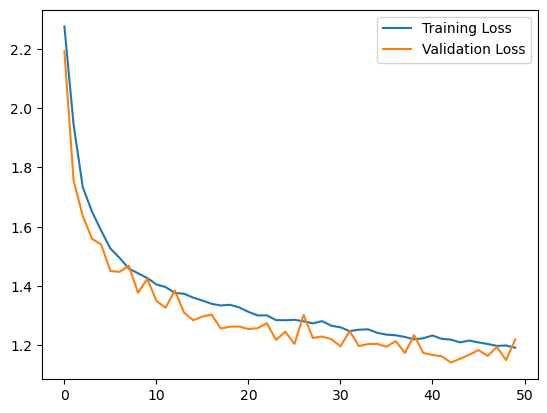

In [56]:
net2 = Net(features=[256,128], drop_rate=.2, learning_rate=.001, momentum=.9)
train_loss_history2, val_loss_history2 = net2.train_it(epochs=50)

plt.plot(train_loss_history2, label="Training Loss")
plt.plot(val_loss_history2, label="Validation Loss")
plt.legend()
plt.show()

In [45]:
net2.test_it()

Test Loss = 0.6145713264942168
Test Accuracy = 84.15%
